# Functions and imports declaration

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import  metrics
import datetime
#Function declaration
 #these are just the functions that'll be used later in the code

def CleanHolidays(dfi, hol):
    #dfi["WorkHour"] = True
    dfi["Holiday"] = 0
    for i in hol:
        date = i
        datel = date.split(".")
        #for j in range(len(datel)):
            #datel[j] = datel[j].strip("0")
        d = str(datel[0] + "-" + datel[1] + "-" + datel[2])
        index_names = dfi[dfi['Date'].str.contains(d)].index
        dfi.loc[index_names, "Holiday"] = 1
    dfi.reset_index(drop=True, inplace=True)
    return dfi

def NaNcheck(dfi):
    c = 0
    f = 0
    for i in dfi.iterrows():
        if "NaN" in str(i):
            print("NaN present at row n° " + str(c) + " in " + str(i))
            f = 1
        else:
            c += 1
    if f == 0: print("NaN check ok")
    return c

def AddMeteo(dfm, dfi):
    dfi["temp_C"] = dfm["temp_C"]
    dfi["solarRad_W/m2"] = dfm["solarRad_W/m2"]
    dfi["windSpeed_m/s"]=dfm["windSpeed_m/s"]
    dfi["rain_day"]=dfm["rain_day"]
    return dfi

def AddWeekDay(dfi):
    w = []
    ci=8760
    for i in range(ci):
        for j in range(24):
            r = i // 7
            w.append((i - (i // 7) * 7))
    dw = pd.DataFrame(w)
    dfi["WeekDay"]=dw
    dfi.reset_index(drop=True, inplace=True)
    return dfi

#def AddDayHour(dfi):
    #dfi["Date_start"] = pd.to_datetime(dfi["Date_start"])
    #dfi['Date'] = dfi['Date_start'].dt.strftime('%d-%m-%Y')
    #dfi['Hour'] = dfi['Date_start'].dt.strftime('%H')
    #return dfi
def RearrangeCol(dfi):
    dfi=dfi[["Date_start","Date","Hour","Power_kW","WeekDay","temp_C","solarRad_W/m2","Holiday","Season", "rain_day","Season_name"]]
    return dfi
def RearrangeCol_2(dfi):
    dfi=dfi[["Date_start","Date","Hour","Power_kW","WeekDay","temp_C","solarRad_W/m2","Holiday","Season", "rain_day","Power-1","Season_name"]]
    return dfi
def AddSeason(dfi):
    dfi.loc[:1898, "Season"]= 1
    dfi.loc[:1898, "Season_name"]= "Winter"
    dfi.loc[1898:4105,"Season"] = 2
    dfi.loc[1898:4105,"Season_name"] = "Spring"
    dfi.loc[4105:6313, "Season"] = 3
    dfi.loc[4105:6313, "Season_name"] = "Summer"
    dfi.loc[6313:8474, "Season"] = 4
    dfi.loc[6313:8474, "Season_name"] = "Autumn"
    dfi.loc[8474:,"Season"] = 1
    dfi.loc[8474:,"Season_name"] = "Winter"
    return(dfi)

def IQRClean(dfi):
    Q1 = dfi['Power_kW'].quantile(0.25)
    Q3 = dfi['Power_kW'].quantile(0.75)
    IQR = Q3 - Q1
    dfi = dfi[((dfi['Power_kW'] > (Q1 - 1.5 * IQR)) & (dfi['Power_kW'] < (Q3 + 1.5 * IQR)))]
    dfi["Power_kW"] = dfi["Power_kW"].interpolate(method="linear")
    return dfi

def fixdates(dfi,flagy):
    #dfi["Date_start"] = pd.to_datetime(dfi["Date_start"])
    d=[]
    he=[]
    h=[]
    merge=[]
    f=0
    gg=0
    mm=0
    if flagy==17: aa="2017"
    if flagy==18: aa="2018"
    g31=[1,3,5,7,8,10,12]
    g30=[4,6,9,11]
    for mm in range(1, 13):
        if mm in g31:
            gm = 31
        elif mm in g30:
            gm = 30
        else:
            gm = 28
        for gg in range(1,gm+1):
            if len(str(gg))<2:
                gg="0" + str(gg)
            if len(str(mm))<2:
                mm="0" +str(mm)
            for jj in range(24):
                d.append(str(gg)+ "-"+ str(mm)+ "-" + aa)
    print("length is:", len(d))
    for j in range(365):
        for i in range(24):
            he.append(i)
            if len(str(i))<2:
                i="0"+ str(i)
            hh=str(i)+ ":00:00"
            h.append(hh)
    for i in range(len(d)):
        merge.append(d[i] + " " + h[i])
    dff = pd.DataFrame(merge)
    ddf=pd.DataFrame(d)
    dhf=pd.DataFrame(he)
    dfi["Date_start"]=dff
    dfi["Date"]=ddf
    dfi["Hour"]=dhf
    #dfi["Date_start"]=pd.to_datetime(dfi["Date_start"],format="%d-%m-%Y %H:%M:%S")
    return(dfi)

def Bootstrapping():

    df_data=pd.read_csv('final.csv')
    df_data['Date_start'] = pd.to_datetime (df_data['Date_start'], format="%Y-%m-%d %H:%M:%S") # create a new column 'data time' of datetime type
    df_data = df_data.set_index('Date_start') # make 'datetime' into index
    print(df_data.head())

    # recurrent
    X=df_data.values
    Y=X[:,2]
    X=X[:,[3,4,5,6,7,9,11]] 
    X_train, X_test, y_train, y_test = train_test_split(X,Y)
    #print(X_train)
    #print(y_train)

    from sklearn.ensemble import BaggingRegressor

    BT_model = BaggingRegressor()
    BT_model.fit(X_train, y_train)
    y_pred_BT =BT_model.predict(X_test)

    MAE_BT=metrics.mean_absolute_error(y_test,y_pred_BT) 
    MSE_BT=metrics.mean_squared_error(y_test,y_pred_BT)  
    RMSE_BT= np.sqrt(metrics.mean_squared_error(y_test,y_pred_BT))
    cvRMSE_BT=RMSE_BT/np.mean(y_test)
    print("\n")
    print(MAE_BT,MSE_BT,RMSE_BT,cvRMSE_BT)

    plt.plot(y_test[1:200])
    plt.plot(y_pred_BT[1:200])
    plt.show()
    plt.scatter(y_test,y_pred_BT)
    dfdata=pd.DataFrame(y_test)
    dfdata.rename(columns={dfdata.columns[0]: "y_test"}, inplace=True)
    dfdata["y_pred"]=pd.DataFrame(y_pred_BT)
    dfdata.to_csv("dfdata_2017.csv")
    derr=[MAE_BT,MSE_BT,RMSE_BT,cvRMSE_BT]
    dferr=pd.DataFrame(derr)
    dferr.to_csv("err_2017.csv")


# MAIN

In [2]:

#data reading
df_raw17=pd.read_csv("IST_South_Tower_2017_Ene_Cons.csv")
df_raw18=pd.read_csv("IST_South_Tower_2018_Ene_Cons.csv")
#meteo cleaning
dfm = pd.read_csv("IST_meteo_data_2017_2018_2019.csv")
dfm.rename(columns={'yyyy-mm-dd hh:mm:ss': 'Date'}, inplace=True)
dfm=dfm.iloc[::12]
dfm.reset_index(drop=True, inplace=True)
# checking existing NaN values
print("NaNcheck before cleaning:")
#NaNcheck(df_raw)
df_raw17=fixdates(df_raw17,17)
df_raw18=fixdates(df_raw18,18)
# Adding WD, tempc and solarrad
df_raw17=AddWeekDay(df_raw17)
df_raw17=AddMeteo(dfm, df_raw17)
df_raw17 = AddSeason(df_raw17)
df_raw18=AddWeekDay(df_raw18)
df_raw18=AddMeteo(dfm, df_raw18)
df_raw18 = AddSeason(df_raw18)
hol=pd.read_csv("holiday_17_18_19.csv")
hol=hol.iloc[:, 0]
# Cleaning holidays + reset indexes
df17=CleanHolidays(df_raw17, hol)
df18=CleanHolidays(df_raw18,hol)
#df= AddDayHour(df)
#print("Check4")
#print(df)
df17=RearrangeCol(df17)
df18=RearrangeCol(df18)
#df.set_index('Date_start', inplace=True)
df17['Power-1'] = df17['Power_kW'].shift(1, fill_value=df17["Power_kW"].iloc[-1])
df18['Power-1'] = df18['Power_kW'].shift(1, fill_value=df18["Power_kW"].iloc[-1])
df17=RearrangeCol_2(df17)
df18=RearrangeCol_2(df18)
df17['Date_start']= pd.to_datetime(df17['Date_start'],dayfirst=True)
df18['Date_start']= pd.to_datetime(df18['Date_start'],dayfirst=True)
df18["hour"]=df18["Hour"]
df17["hour"]=df17["Hour"]
df17['Hour'] = pd.to_datetime(df17['Hour'],format= '%H' ).dt.time
df18['Hour'] = pd.to_datetime(df18['Hour'],format= '%H' ).dt.time
df17.set_index('Date_start', inplace=True)
df18.set_index('Date_start', inplace=True)
#Outliers cleaning  
print("NaNcheck after cleaning:")
#NaNcheck(df)

NaNcheck before cleaning:
length is: 8760
length is: 8760
NaNcheck after cleaning:


# Merge

In [3]:
df=pd.concat([df17, df18])
df

,Date,Hour,Power_kW,WeekDay,temp_C,solarRad_W/m2,Holiday,Season,rain_day,Power-1,Season_name,hour
Date_start,,,,,,,,,,,,
2017-01-01 00:00:00,01-01-2017,00:00:00,100.810001,0,8.720,1.163,1,1.0,0.0,79.176097,Winter,0
2017-01-01 01:00:00,01-01-2017,01:00:00,99.054135,0,8.210,1.357,1,1.0,0.0,100.810001,Winter,1
2017-01-01 02:00:00,01-01-2017,02:00:00,98.539567,0,7.580,2.604,1,1.0,0.0,99.054135,Winter,2
2017-01-01 03:00:00,01-01-2017,03:00:00,101.435784,0,6.968,1.440,1,1.0,0.0,98.539567,Winter,3
2017-01-01 04:00:00,01-01-2017,04:00:00,98.481665,0,6.797,1.773,1,1.0,0.0,101.435784,Winter,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,31-12-2018,19:00:00,97.217861,0,11.880,542.500,0,1.0,0.0,105.247736,Winter,19
2018-12-31 20:00:00,31-12-2018,20:00:00,95.928710,0,12.190,503.200,0,1.0,0.0,97.217861,Winter,20
2018-12-31 21:00:00,31-12-2018,21:00:00,85.652000,0,11.330,311.200,0,1.0,0.0,95.928710,Winter,21


# Exploratory data analysis

## Plot data

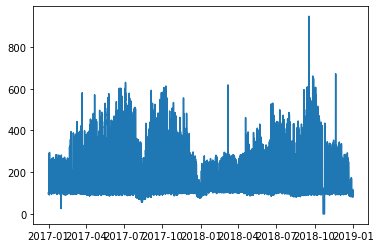

In [4]:
plt.plot(df["Power_kW"])

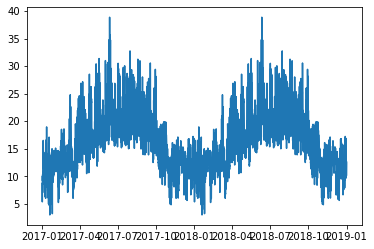

In [5]:
plt.plot(df["temp_C"])

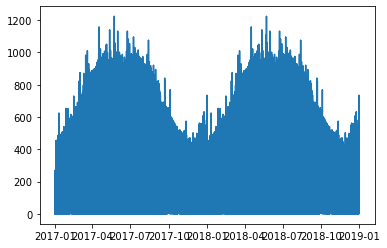

In [6]:
plt.plot(df["solarRad_W/m2"])

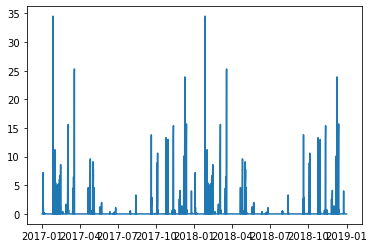

In [7]:
plt.plot(df["rain_day"])

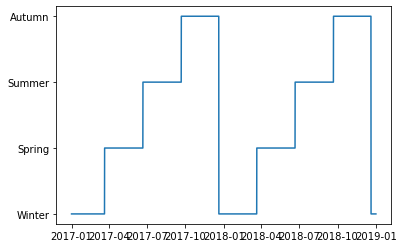

In [8]:
plt.plot(df["Season_name"])

(array([8.800e+01, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        4.200e+01, 1.250e+02, 3.830e+02, 1.444e+03, 3.892e+03, 3.252e+03,
        9.570e+02, 4.240e+02, 3.540e+02, 2.860e+02, 1.860e+02, 1.620e+02,
        2.090e+02, 2.090e+02, 1.480e+02, 1.490e+02, 1.770e+02, 2.140e+02,
        2.630e+02, 3.050e+02, 3.250e+02, 3.050e+02, 2.600e+02, 2.380e+02,
        1.800e+02, 1.940e+02, 2.280e+02, 1.770e+02, 1.670e+02, 1.720e+02,
        1.460e+02, 1.470e+02, 1.520e+02, 1.430e+02, 1.310e+02, 1.380e+02,
        1.220e+02, 1.160e+02, 9.400e+01, 8.600e+01, 8.800e+01, 8.700e+01,
        6.200e+01, 6.500e+01, 5.100e+01, 5.100e+01, 4.800e+01, 5.000e+01,
        3.400e+01, 3.700e+01, 2.700e+01, 2.400e+01, 1.800e+01, 1.400e+01,
        1.000e+01, 1.300e+01, 8.000e+00, 1.200e+01, 7.000e+00, 4.000e+00,
        3.000e+00, 8.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

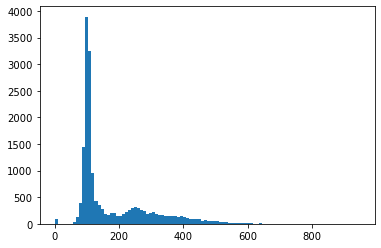

In [9]:
plt.hist(df["Power_kW"],100)

(array([  36.,  206.,  552., 1164., 2024., 2466., 2308., 2416., 2108.,
        1516., 1044.,  660.,  424.,  312.,  160.,   72.,   14.,   22.,
          10.,    6.]),
 array([ 3.014 ,  4.8063,  6.5986,  8.3909, 10.1832, 11.9755, 13.7678,
        15.5601, 17.3524, 19.1447, 20.937 , 22.7293, 24.5216, 26.3139,
        28.1062, 29.8985, 31.6908, 33.4831, 35.2754, 37.0677, 38.86  ]),
 <BarContainer object of 20 artists>)

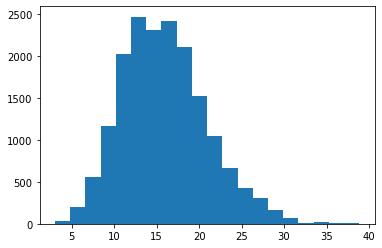

In [10]:
plt.hist(df["temp_C"],20)

## Data analysis

### Power consumption vs working/holiday days

In [11]:
#splitting between holiday data and working days data
df_hol=df[(df["Holiday"]==True) | (df["WeekDay"]==6)]
df_workd=df[(df["Holiday"]==False) & (df["WeekDay"] !=6)]
df_workd

,Date,Hour,Power_kW,WeekDay,temp_C,solarRad_W/m2,Holiday,Season,rain_day,Power-1,Season_name,hour
Date_start,,,,,,,,,,,,
2017-01-02 00:00:00,02-01-2017,00:00:00,92.215521,1,9.64,1.496,0,1.0,0.0,97.656390,Winter,0
2017-01-02 01:00:00,02-01-2017,01:00:00,94.693530,1,9.57,1.136,0,1.0,0.0,92.215521,Winter,1
2017-01-02 02:00:00,02-01-2017,02:00:00,97.909850,1,9.97,2.521,0,1.0,0.0,94.693530,Winter,2
2017-01-02 03:00:00,02-01-2017,03:00:00,95.432934,1,9.80,1.329,0,1.0,0.0,97.909850,Winter,3
2017-01-02 04:00:00,02-01-2017,04:00:00,95.678309,1,9.83,2.520,0,1.0,0.0,95.432934,Winter,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,31-12-2018,19:00:00,97.217861,0,11.88,542.500,0,1.0,0.0,105.247736,Winter,19
2018-12-31 20:00:00,31-12-2018,20:00:00,95.928710,0,12.19,503.200,0,1.0,0.0,97.217861,Winter,20
2018-12-31 21:00:00,31-12-2018,21:00:00,85.652000,0,11.33,311.200,0,1.0,0.0,95.928710,Winter,21


(50.0, 500.0)

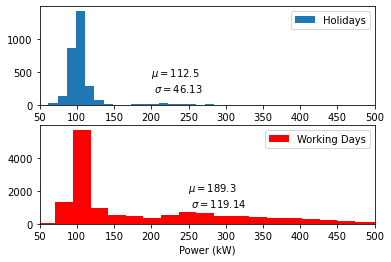

In [12]:
powHol=df_hol["Power_kW"]
powWD=df_workd["Power_kW"]
#Compute mu and sigma
mu_powHol=np.mean(powHol)
sig_powHol=np.std(powHol)
mu_powWD=np.mean(powWD)
sig_powWD=np.std(powWD)
#Draw the actual histograms
fig2, ax2=plt.subplots(2,1)
infoHol=f"$\mu={mu_powHol:.1f}$\n $\sigma={sig_powHol:.2f}$"
infoWD=f"$\mu={mu_powWD:.1f}$\n $\sigma={sig_powWD:.2f}$"
ax2[0].hist(powHol,bins=40, label="Holidays")
ax2[0].text(200,200,infoHol)
ax2[0].legend()
ax2[0].set_xlim(50,500)
ax2[1].hist(powWD,bins=40, label="Working Days", color="red")
ax2[1].text(250, 1000, infoWD)
ax2[1].legend()
ax2[1].set_xlabel("Power (kW)")
ax2[1].set_xlim(50,500)

Text(0.5, 0, 'Time of day (h)')

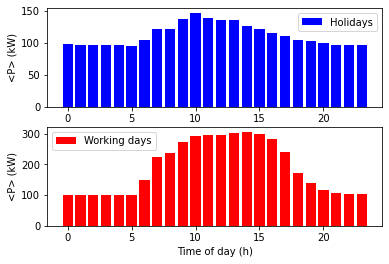

In [13]:
powBars=np.zeros(24)
powBarsH=np.zeros(24)
powBarsW=np.zeros(24)
for h in range(24):
    df_hour=df.where(df["hour"]==h)
    powBars[h]=np.mean(df_hour["Power_kW"])
    powBarsH[h]=np.mean(df_hol.where(df_hol.hour==h)["Power_kW"])
    powBarsW[h]=np.mean(df_workd.where(df_workd.hour==h)["Power_kW"])
fig4, ax4=plt.subplots(2,1)
hr=np.arange(24)

ax4[0].bar(hr,powBarsH, label="Holidays", color="blue")
ax4[0].legend()
ax4[0].set_ylabel("<P> (kW)")
ax4[1].bar(hr,powBarsW, label="Working days", color="red")
ax4[1].legend()
ax4[1].set_ylabel("<P> (kW)")
ax4[1].set_xlabel("Time of day (h)")

#apart from some peaks the overall consumption during holidays is almost constant and 
#much lower than the consumption during working days

### Power consumption vs working hours/not working hours

In [14]:
#without considering holidays
df_wh=df_workd.between_time('08:00:00', '20:00:00')
df_notwh=df_workd.between_time('21:00:00','07:00:00')
df_wh

,Date,Hour,Power_kW,WeekDay,temp_C,solarRad_W/m2,Holiday,Season,rain_day,Power-1,Season_name,hour
Date_start,,,,,,,,,,,,
2017-01-02 08:00:00,02-01-2017,08:00:00,283.762017,1,10.16,1.495,0,1.0,0.0,133.987914,Winter,8
2017-01-02 09:00:00,02-01-2017,09:00:00,240.998945,1,10.15,31.380,0,1.0,0.0,283.762017,Winter,9
2017-01-02 10:00:00,02-01-2017,10:00:00,263.492864,1,10.75,59.380,0,1.0,0.0,240.998945,Winter,10
2017-01-02 11:00:00,02-01-2017,11:00:00,280.419186,1,11.21,53.120,0,1.0,0.0,263.492864,Winter,11
2017-01-02 12:00:00,02-01-2017,12:00:00,279.796461,1,12.36,107.600,0,1.0,0.0,280.419186,Winter,12
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 16:00:00,31-12-2018,16:00:00,103.270310,0,11.73,112.400,0,1.0,0.0,109.388311,Winter,16
2018-12-31 17:00:00,31-12-2018,17:00:00,102.152465,0,11.95,675.500,0,1.0,0.0,103.270310,Winter,17
2018-12-31 18:00:00,31-12-2018,18:00:00,105.247736,0,12.70,735.000,0,1.0,0.0,102.152465,Winter,18


Text(0, 0.5, 'P [kW]')

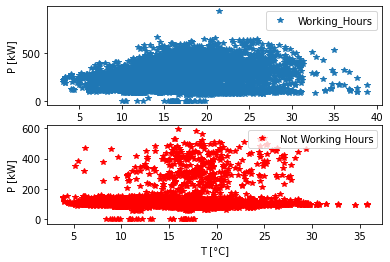

In [15]:
fig5, ax5=plt.subplots(2,1)
xWH=df_wh["temp_C"]
yWH=df_wh["Power_kW"]
ax5[0].plot(xWH,yWH,"*",label="Working_Hours")
ax5[0].set_ylabel("P [kW]")
ax5[0].legend()
xNWH=df_notwh["temp_C"]
yNWH=df_notwh["Power_kW"]
ax5[1].plot(xNWH,yNWH,"*",label="Not Working Hours",color="red")
ax5[1].legend()
ax5[1].set_xlabel("T [°C]")
ax5[1].set_ylabel("P [kW]")

# As we can see there is some correlation between hour and temperature only on working hours, 
# otherwise it is mostly below 200 kW

(50.0, 500.0)

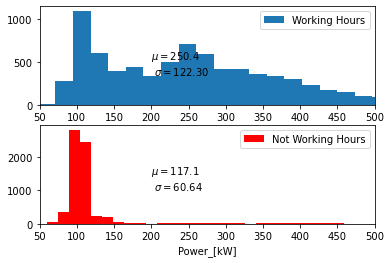

In [16]:
powWH=df_wh["Power_kW"]
powNWH=df_notwh["Power_kW"]
#Compute mu and sigma of power during holidays and working days
mu_powWH=np.mean(powWH)
sig_powWH=np.std(powWH)
mu_powNWH=np.mean(powNWH)
sig_powNWH=np.std(powNWH)
#Draw the actual histograms
fig6, ax6=plt.subplots(2,1)
infoWH=f"$\mu={mu_powWH:.1f}$\n $\sigma={sig_powWH:.2f}$"
infoNWH=f"$\mu={mu_powNWH:.1f}$\n $\sigma={sig_powNWH:.2f}$"
ax6[0].hist(powWH,bins=40, label="Working Hours")
ax6[0].text(200,350,infoWH)
ax6[0].legend()
ax6[0].set_xlim(50,500)
ax6[1].hist(powNWH,bins=40, label="Not Working Hours", color="red")
ax6[1].text(200, 1000, infoNWH)
ax6[1].legend()
ax6[1].set_xlabel("Power_[kW]")
ax6[1].set_xlim(50,500)

#Regarding the working hours there are two main peaks, at 1000 kW and 400 kW (give or take)
#Regarding not working hours the consumption is much lower and much more constant throughout time, with a peak at 3000 kW (give or take)
#We can say that these two plots highlights even more the fact that there is a clear correlation between hour and consumption
#only during working days, otherwise it is pretty constant

## Basic statistics

In [17]:
df.describe()

,Power_kW,WeekDay,temp_C,solarRad_W/m2,Holiday,Season,rain_day,Power-1,hour
count,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000
mean,175.731324,2.991781,15.944250,198.557296,0.038356,2.496119,0.553916,175.731324,11.500000
std,113.664489,2.003462,5.011188,285.839433,0.192060,1.114480,2.495952,113.664489,6.922384
min,0.000000,0.000000,3.014000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,100.669286,1.000000,12.230000,1.136000,0.000000,2.000000,0.000000,100.669286,5.750000
50%,111.587622,3.000000,15.570000,6.968000,0.000000,2.000000,0.000000,111.587622,11.500000
75%,242.475295,5.000000,18.990000,350.525000,0.000000,3.000000,0.000000,242.475295,17.250000
max,947.059190,6.000000,38.860000,1224.000000,1.000000,4.000000,34.500000,947.059190,23.000000


In [18]:
df_sortkW = df.sort_values(by = 'Power_kW', ascending = True)
df_sortkW [:9]

,Date,Hour,Power_kW,WeekDay,temp_C,solarRad_W/m2,Holiday,Season,rain_day,Power-1,Season_name,hour
Date_start,,,,,,,,,,,,
2018-10-22 15:00:00,22-10-2018,15:00:00,0.0,0,17.49,140.000,0,4.0,0.0,0.0,Autumn,15
2018-10-22 06:00:00,22-10-2018,06:00:00,0.0,0,8.41,3.269,0,4.0,0.0,0.0,Autumn,6
2018-10-22 07:00:00,22-10-2018,07:00:00,0.0,0,9.00,98.400,0,4.0,0.0,0.0,Autumn,7
2018-10-22 08:00:00,22-10-2018,08:00:00,0.0,0,10.34,250.700,0,4.0,0.0,0.0,Autumn,8
2018-10-22 09:00:00,22-10-2018,09:00:00,0.0,0,11.84,385.500,0,4.0,0.0,0.0,Autumn,9
2018-10-22 10:00:00,22-10-2018,10:00:00,0.0,0,15.88,519.800,0,4.0,0.0,0.0,Autumn,10
2018-10-22 11:00:00,22-10-2018,11:00:00,0.0,0,16.27,513.200,0,4.0,0.0,0.0,Autumn,11
2018-10-22 12:00:00,22-10-2018,12:00:00,0.0,0,18.44,494.800,0,4.0,0.0,0.0,Autumn,12
2018-10-22 13:00:00,22-10-2018,13:00:00,0.0,0,18.65,426.900,0,4.0,0.0,0.0,Autumn,13


In [19]:
df_sortkW = df.sort_values(by = 'Power_kW', ascending = False) 
df_sortkW [:9]

,Date,Hour,Power_kW,WeekDay,temp_C,solarRad_W/m2,Holiday,Season,rain_day,Power-1,Season_name,hour
Date_start,,,,,,,,,,,,
2018-09-17 16:00:00,17-09-2018,16:00:00,947.059190,0,21.48,1.910,0,3.0,0.0,621.344736,Summer,16
2018-11-20 15:00:00,20-11-2018,15:00:00,671.567397,1,14.17,34.330,0,4.0,0.0,306.022579,Autumn,15
2018-09-26 14:00:00,26-09-2018,14:00:00,660.638464,2,20.92,0.637,0,4.0,0.0,640.113886,Autumn,14
2018-09-27 11:00:00,27-09-2018,11:00:00,651.079090,3,19.63,223.700,0,4.0,0.0,640.703836,Autumn,11
2018-09-28 11:00:00,28-09-2018,11:00:00,649.392925,4,25.89,268.400,0,4.0,0.1,604.418414,Autumn,11
2018-09-27 10:00:00,27-09-2018,10:00:00,640.703836,3,20.41,435.400,0,4.0,0.0,608.274939,Autumn,10
2018-09-28 14:00:00,28-09-2018,14:00:00,640.317964,4,25.08,6.087,0,4.0,0.1,637.954450,Autumn,14
2018-09-26 13:00:00,26-09-2018,13:00:00,640.113886,2,23.03,2.020,0,4.0,0.0,637.925389,Autumn,13
2018-09-26 11:00:00,26-09-2018,11:00:00,638.449789,2,24.27,288.700,0,4.0,0.0,627.495511,Autumn,11


{'whiskers': [<matplotlib.lines.Line2D at 0x257dda051c0>,
 'caps': [<matplotlib.lines.Line2D at 0x257dda71d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x257dda05c70>],
 'medians': [<matplotlib.lines.Line2D at 0x257dda71fa0>],
 'fliers': [<matplotlib.lines.Line2D at 0x257dda71610>],
 'means': []}

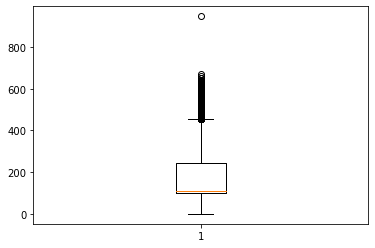

In [20]:
plt.boxplot(df['Power_kW'])

## Outliers removal

In [21]:
df17=IQRClean(df17)  
df18=IQRClean(df18)
df=IQRClean(df)

<ipython-input-1-e3bb7649f229>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfi["Power_kW"] = dfi["Power_kW"].interpolate(method="linear")
<ipython-input-1-e3bb7649f229>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfi["Power_kW"] = dfi["Power_kW"].interpolate(method="linear")
<ipython-input-1-e3bb7649f229>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

# Clustering

In [22]:
df

,Date,Hour,Power_kW,WeekDay,temp_C,solarRad_W/m2,Holiday,Season,rain_day,Power-1,Season_name,hour
Date_start,,,,,,,,,,,,
2017-01-01 00:00:00,01-01-2017,00:00:00,100.810001,0,8.720,1.163,1,1.0,0.0,79.176097,Winter,0
2017-01-01 01:00:00,01-01-2017,01:00:00,99.054135,0,8.210,1.357,1,1.0,0.0,100.810001,Winter,1
2017-01-01 02:00:00,01-01-2017,02:00:00,98.539567,0,7.580,2.604,1,1.0,0.0,99.054135,Winter,2
2017-01-01 03:00:00,01-01-2017,03:00:00,101.435784,0,6.968,1.440,1,1.0,0.0,98.539567,Winter,3
2017-01-01 04:00:00,01-01-2017,04:00:00,98.481665,0,6.797,1.773,1,1.0,0.0,101.435784,Winter,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,31-12-2018,19:00:00,97.217861,0,11.880,542.500,0,1.0,0.0,105.247736,Winter,19
2018-12-31 20:00:00,31-12-2018,20:00:00,95.928710,0,12.190,503.200,0,1.0,0.0,97.217861,Winter,20
2018-12-31 21:00:00,31-12-2018,21:00:00,85.652000,0,11.330,311.200,0,1.0,0.0,95.928710,Winter,21


In [23]:
dfc=df
dfc['date']=dfc.index.date
dfc['hour']=dfc.index.hour
dfc = dfc.set_index ('date', drop = True)
cluster_data=dfc[["Power_kW","temp_C","solarRad_W/m2","Season","WeekDay","rain_day","hour"]]
cluster_data

<ipython-input-23-b18b048944f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc['date']=dfc.index.date
<ipython-input-23-b18b048944f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc['hour']=dfc.index.hour


,Power_kW,temp_C,solarRad_W/m2,Season,WeekDay,rain_day,hour
date,,,,,,,
2017-01-01,100.810001,8.720,1.163,1.0,0,0.0,0
2017-01-01,99.054135,8.210,1.357,1.0,0,0.0,1
2017-01-01,98.539567,7.580,2.604,1.0,0,0.0,2
2017-01-01,101.435784,6.968,1.440,1.0,0,0.0,3
2017-01-01,98.481665,6.797,1.773,1.0,0,0.0,4
...,...,...,...,...,...,...,...
2018-12-31,97.217861,11.880,542.500,1.0,0,0.0,19
2018-12-31,95.928710,12.190,503.200,1.0,0,0.0,20
2018-12-31,85.652000,11.330,311.200,1.0,0,0.0,21


## K-means

In [24]:
# import KMeans
from sklearn.cluster import KMeans
from pandas import DataFrame

In [25]:
# create kmeans object

model = KMeans(n_clusters=3).fit(cluster_data)
pred = model.labels_

pred

array([0, 0, 0, ..., 2, 0, 0])

Text(0.5, 1.0, 'Elbow Curve')

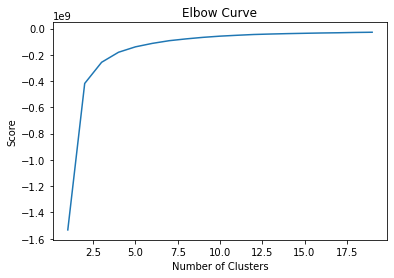

In [26]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(cluster_data).score(cluster_data) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')

In [27]:
cluster_data['Cluster']=pred
cluster_data

<ipython-input-27-f365e134cc4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['Cluster']=pred


,Power_kW,temp_C,solarRad_W/m2,Season,WeekDay,rain_day,hour,Cluster
date,,,,,,,,
2017-01-01,100.810001,8.720,1.163,1.0,0,0.0,0,0
2017-01-01,99.054135,8.210,1.357,1.0,0,0.0,1,0
2017-01-01,98.539567,7.580,2.604,1.0,0,0.0,2,0
2017-01-01,101.435784,6.968,1.440,1.0,0,0.0,3,0
2017-01-01,98.481665,6.797,1.773,1.0,0,0.0,4,0
...,...,...,...,...,...,...,...,...
2018-12-31,97.217861,11.880,542.500,1.0,0,0.0,19,2
2018-12-31,95.928710,12.190,503.200,1.0,0,0.0,20,2
2018-12-31,85.652000,11.330,311.200,1.0,0,0.0,21,2


<AxesSubplot:xlabel='hour'>

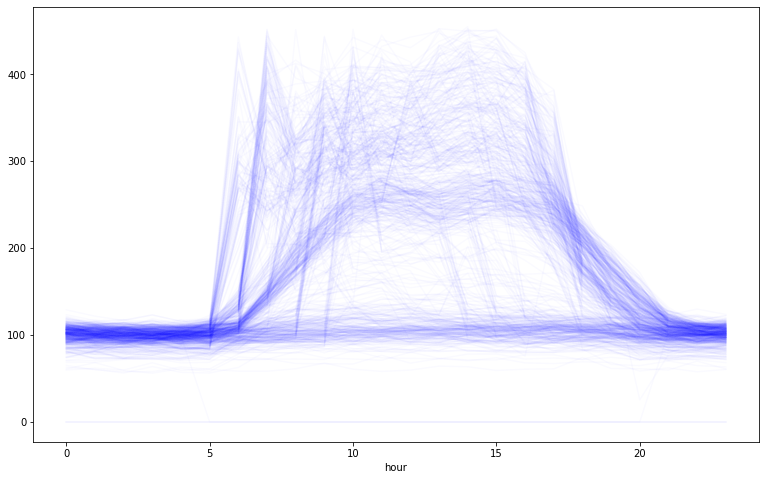

In [28]:
dfj=cluster_data
dfj=dfj.drop(columns=['temp_C','solarRad_W/m2','rain_day','WeekDay','Cluster'])
dfj.rename(columns = {'Power_kW': 'Power'}, inplace = True)


df_pivot=dfj.groupby(by=['date', 'hour']).Power.sum().unstack()
df_pivot = df_pivot.dropna()
df_pivot.T.plot(figsize=(13,8), legend=False, color='blue', alpha=0.02)

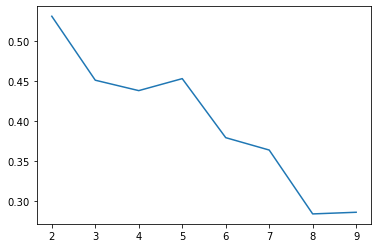

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score


sillhoute_scores = []
n_cluster_list = np.arange(2,10).astype(int)

X = df_pivot.values.copy()

    
sc = MinMaxScaler()
X = sc.fit_transform(X)

for n_cluster in n_cluster_list:
    
    kmeans = KMeans(n_clusters=n_cluster)
    cluster_found = kmeans.fit_predict(X)
    sillhoute_scores.append(silhouette_score(X, kmeans.labels_))
    
plt.plot(n_cluster_list,sillhoute_scores)

In [30]:
kmeans = KMeans(n_clusters=3)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name='cluster')
df_pivot = df_pivot.set_index(cluster_found_sr, append=True )

Text(0.5, 0, 'hour')

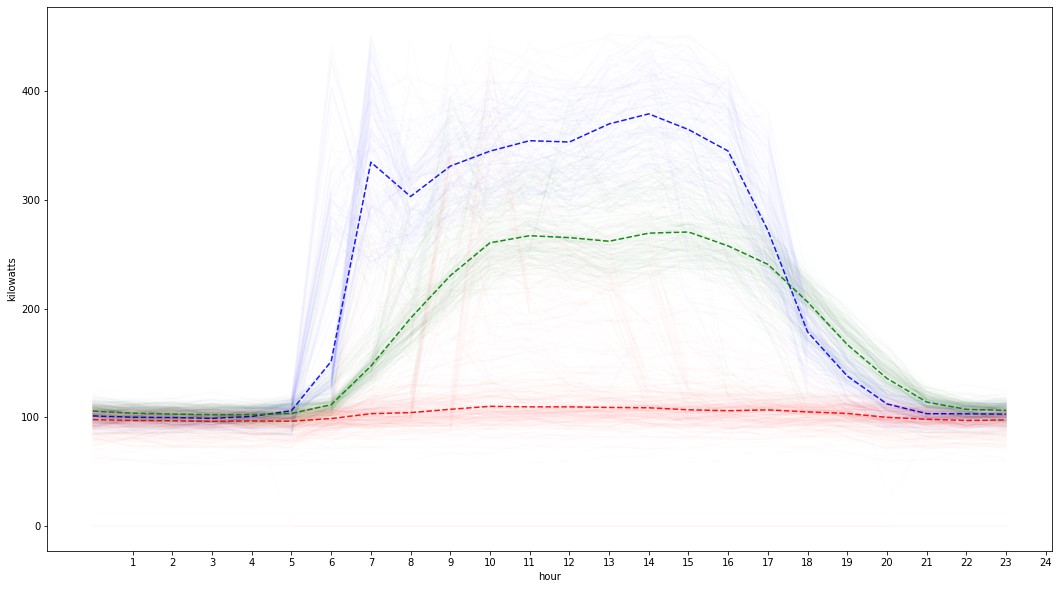

In [31]:
fig, ax= plt.subplots(1,1, figsize=(18,10))
color_list = ['blue','red','green']
cluster_values = sorted(df_pivot.index.get_level_values('cluster').unique())
#for each cluster I assign a colour
for cluster, color in zip(cluster_values, color_list):
    df_pivot.xs(cluster, level=1).T.plot(
        ax=ax, legend=False, alpha=0.01, color=color, label= f'Cluster {cluster}'
        )
    df_pivot.xs(cluster, level=1).median().plot(
        ax=ax, color=color, alpha=0.9, ls='--'
    )

ax.set_xticks(np.arange(1,25))
ax.set_ylabel('kilowatts')
ax.set_xlabel('hour')

In [32]:
#the plot above shows that there are three main clusters: the blue one probably
#characterized by the not working hours, while the others are from the working hours.
#The green one highlight the period in which the overall consumption is higher,
#with respect to the red one: this division could be characterized by the seasonal change,
#as in summer there usually is an increase in the energy demand due to the cooling demand

# Feature selection

In [33]:
dff=df
dff

,Date,Hour,Power_kW,WeekDay,temp_C,solarRad_W/m2,Holiday,Season,rain_day,Power-1,Season_name,hour,date
Date_start,,,,,,,,,,,,,
2017-01-01 00:00:00,01-01-2017,00:00:00,100.810001,0,8.720,1.163,1,1.0,0.0,79.176097,Winter,0,2017-01-01
2017-01-01 01:00:00,01-01-2017,01:00:00,99.054135,0,8.210,1.357,1,1.0,0.0,100.810001,Winter,1,2017-01-01
2017-01-01 02:00:00,01-01-2017,02:00:00,98.539567,0,7.580,2.604,1,1.0,0.0,99.054135,Winter,2,2017-01-01
2017-01-01 03:00:00,01-01-2017,03:00:00,101.435784,0,6.968,1.440,1,1.0,0.0,98.539567,Winter,3,2017-01-01
2017-01-01 04:00:00,01-01-2017,04:00:00,98.481665,0,6.797,1.773,1,1.0,0.0,101.435784,Winter,4,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,31-12-2018,19:00:00,97.217861,0,11.880,542.500,0,1.0,0.0,105.247736,Winter,19,2018-12-31
2018-12-31 20:00:00,31-12-2018,20:00:00,95.928710,0,12.190,503.200,0,1.0,0.0,97.217861,Winter,20,2018-12-31
2018-12-31 21:00:00,31-12-2018,21:00:00,85.652000,0,11.330,311.200,0,1.0,0.0,95.928710,Winter,21,2018-12-31


In [34]:
dff=dff.drop(columns=['Hour',"Date","date","Season_name"])
dff=dff.dropna()
dff

,Power_kW,WeekDay,temp_C,solarRad_W/m2,Holiday,Season,rain_day,Power-1,hour
Date_start,,,,,,,,,
2017-01-01 00:00:00,100.810001,0,8.720,1.163,1,1.0,0.0,79.176097,0
2017-01-01 01:00:00,99.054135,0,8.210,1.357,1,1.0,0.0,100.810001,1
2017-01-01 02:00:00,98.539567,0,7.580,2.604,1,1.0,0.0,99.054135,2
2017-01-01 03:00:00,101.435784,0,6.968,1.440,1,1.0,0.0,98.539567,3
2017-01-01 04:00:00,98.481665,0,6.797,1.773,1,1.0,0.0,101.435784,4
...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,97.217861,0,11.880,542.500,0,1.0,0.0,105.247736,19
2018-12-31 20:00:00,95.928710,0,12.190,503.200,0,1.0,0.0,97.217861,20
2018-12-31 21:00:00,85.652000,0,11.330,311.200,0,1.0,0.0,95.928710,21


In [35]:
X=dff.values 
X

array([[100.8100005,   0.       ,   8.72     , ...,   0.       ,
         79.176097 ,   0.       ],
       [ 99.0541345,   0.       ,   8.21     , ...,   0.       ,
        100.8100005,   1.       ],
       [ 98.539567 ,   0.       ,   7.58     , ...,   0.       ,
         99.0541345,   2.       ],
       ...,
       [ 85.652    ,   0.       ,  11.33     , ...,   0.       ,
         95.9287105,  21.       ],
       [ 90.360675 ,   0.       ,  11.22     , ...,   0.       ,
         85.652    ,  22.       ],
       [ 81.95498  ,   0.       ,  10.25     , ...,   0.       ,
         90.360675 ,  23.       ]])

In [36]:
Y=X[:,0]  
X=X[:,[1,2,3,4,5,6,7,8]]

#print(Y)
print(X)

[[  0.          8.72        1.163     ...   0.         79.176097
    0.       ]
 [  0.          8.21        1.357     ...   0.        100.8100005
    1.       ]
 [  0.          7.58        2.604     ...   0.         99.0541345
    2.       ]
 ...
 [  0.         11.33      311.2       ...   0.         95.9287105
   21.       ]
 [  0.         11.22      126.3       ...   0.         85.652
   22.       ]
 [  0.         10.25        4.431     ...   0.         90.360675
   23.       ]]


## Filter method

### kBest

In [37]:
from sklearn.feature_selection import SelectKBest # selection method
from sklearn.feature_selection import f_regression, mutual_info_regression #score matrix

In [38]:
# 2 FEATURES (k=2) - f-test ANOVA

features=SelectKBest(k=2,score_func=f_regression) # Test different k number of features, uses f-test ANOVA
fit=features.fit(X,Y) #calculates the f_regression of the features, calculating the correlation
print(fit.scores_)
features_results=fit.transform(X) #which are the best two features
print(features_results) 

#Best features (I, II): Power-1 and Solar Radiation

[2.24233270e+02 3.85766997e+02 4.78131284e+02 1.21840979e+02
 8.75087196e+01 1.19453950e+01 6.87580972e+04 1.52145309e+02]
[[  1.163      79.176097 ]
 [  1.357     100.8100005]
 [  2.604      99.0541345]
 ...
 [311.2        95.9287105]
 [126.3        85.652    ]
 [  4.431      90.360675 ]]


In [39]:
# 2 FEATURES (k=2) - MUTUAL-INFO-REGRESSION

features=SelectKBest(k=2,score_func=mutual_info_regression) 

fit=features.fit(X,Y) #calculates the f_regression of the features, calculating the correlation
print(fit.scores_)
features_results=fit.transform(X) #which are the best two features
print(features_results)

#Best features (I, II) Power -1 and hour

[0.11041162 0.09149602 0.05256597 0.00708484 0.11493091 0.04121074
 1.21245608 0.47116229]
[[ 79.176097    0.       ]
 [100.8100005   1.       ]
 [ 99.0541345   2.       ]
 ...
 [ 95.9287105  21.       ]
 [ 85.652      22.       ]
 [ 90.360675   23.       ]]


In [40]:
# 3 FEATURES (k=3) - f-test ANOVA

features=SelectKBest(k=3,score_func=f_regression) # Test different k number of features, uses f-test ANOVA
fit=features.fit(X,Y) #calculates the f_regression of the features, calculating the correlation
print(fit.scores_)
features_results=fit.transform(X) #which are the best 3 features
print(features_results) 

#Best features (I, II, III): Power-1, Solar Radiation and temperature

[2.24233270e+02 3.85766997e+02 4.78131284e+02 1.21840979e+02
 8.75087196e+01 1.19453950e+01 6.87580972e+04 1.52145309e+02]
[[  8.72        1.163      79.176097 ]
 [  8.21        1.357     100.8100005]
 [  7.58        2.604      99.0541345]
 ...
 [ 11.33      311.2        95.9287105]
 [ 11.22      126.3        85.652    ]
 [ 10.25        4.431      90.360675 ]]


In [41]:
# 3 FEATURES (k=3) - MUTUAL-INFO-REGRESSION

features=SelectKBest(k=3,score_func=mutual_info_regression) 

fit=features.fit(X,Y) #calculates the f_regression of the features, calculating the correlation
print(fit.scores_)
features_results=fit.transform(X) #which are the best 3 features
print(features_results) 

#Best features (I, II, III): Power-1, hour and season

[0.11084879 0.09163762 0.05292159 0.00824481 0.1144274  0.04091341
 1.21203679 0.47143707]
[[  1.         79.176097    0.       ]
 [  1.        100.8100005   1.       ]
 [  1.         99.0541345   2.       ]
 ...
 [  1.         95.9287105  21.       ]
 [  1.         85.652      22.       ]
 [  1.         90.360675   23.       ]]


In [42]:
#Finally we can conclude that the best features are Power-1, solar radiation, hour, temperature and season

## Wrapper methods

### Recursive Feature Elimination (RFE)

In [43]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [44]:
model=LinearRegression() # LinearRegression Model as Estimator
rfe1=RFE(model,n_features_to_select=1)# using 1 feature
rfe2=RFE(model,n_features_to_select=2) # using 2 features
rfe3=RFE(model,n_features_to_select=3) # using 3 features
fit1=rfe1.fit(X,Y)
fit2=rfe2.fit(X,Y)
fit3=rfe3.fit(X,Y)

In [45]:
print( "Feature Ranking (Linear Model, 1 feature): %s" % (fit1.ranking_))
print( "Feature Ranking (Linear Model, 2 features): %s" % (fit2.ranking_)) 
print( "Feature Ranking (Linear Model, 3 features): %s" % (fit3.ranking_))

Feature Ranking (Linear Model, 1 feature): [4 5 8 1 7 6 3 2]
Feature Ranking (Linear Model, 2 features): [3 4 7 1 6 5 2 1]
Feature Ranking (Linear Model, 3 features): [2 3 6 1 5 4 1 1]


# Bootstrapping

### CSV generation 

In [46]:
df17.to_csv("final_2017.csv")
df18.to_csv("final_2018.csv")
df.to_csv("final.csv")
#the algorithms are made so that they get the datas from the final csv, not the dataframe

## Best model evaluation

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import  metrics

### Pre-processing

In [48]:
df_data=pd.read_csv('final.csv')
df_data['Date_start'] = pd.to_datetime (df_data['Date_start'], format="%Y-%m-%d %H:%M:%S")# create a new column 'data time' of datetime type
df_data = df_data.set_index('Date_start') # make 'datetime' into index
df_data.head()

,Date,Hour,Power_kW,WeekDay,temp_C,solarRad_W/m2,Holiday,Season,rain_day,Power-1,Season_name,hour,date
Date_start,,,,,,,,,,,,,
2017-01-01 00:00:00,01-01-2017,00:00:00,100.810001,0,8.720,1.163,1,1.0,0.0,79.176097,Winter,0,2017-01-01
2017-01-01 01:00:00,01-01-2017,01:00:00,99.054135,0,8.210,1.357,1,1.0,0.0,100.810001,Winter,1,2017-01-01
2017-01-01 02:00:00,01-01-2017,02:00:00,98.539567,0,7.580,2.604,1,1.0,0.0,99.054135,Winter,2,2017-01-01
2017-01-01 03:00:00,01-01-2017,03:00:00,101.435784,0,6.968,1.440,1,1.0,0.0,98.539567,Winter,3,2017-01-01
2017-01-01 04:00:00,01-01-2017,04:00:00,98.481664,0,6.797,1.773,1,1.0,0.0,101.435784,Winter,4,2017-01-01


In [49]:
#create lists that'll save all of the error and pick the best one
MAE_BTl=[]
MSE_BTl=[]
RMSE_BTl=[]
cvRMSE_BTl=[]

### Split training and test data

### Several features

In [50]:
# recurrent
X=df_data.values
Y=X[:,2]
X=X[:,[3,4,5,6,7,9,11]] 
#feature 2 (month) and feature 5(Energy-2) do not improve significantly
X

array([[0, 8.72, 1.163, ..., 1.0, 79.176097, 0],
       [0, 8.21, 1.357, ..., 1.0, 100.8100005, 1],
       [0, 7.58, 2.604, ..., 1.0, 99.0541345, 2],
       ...,
       [0, 11.33, 311.2, ..., 1.0, 95.9287105, 21],
       [0, 11.22, 126.3, ..., 1.0, 85.652, 22],
       [0, 10.25, 4.431, ..., 1.0, 90.360675, 23]], dtype=object)

### Split Data into training and test data

In [51]:
#by default, it chooses randomly 75% of the data for training and 25% for testing
X_train, X_test, y_train, y_test = train_test_split(X,Y)
print(X_train)
print(y_train)

[[3 19.63 223.7 ... 4.0 446.9891645 11]
 [1 17.03 1.661 ... 2.0 102.6694355 5]
 [3 17.49 319.6 ... 4.0 104.344675 4]
 ...
 [2 19.06 173.1 ... 4.0 301.2286885 9]
 [5 17.47 10.88 ... 2.0 107.5856855 6]
 [3 12.82 128.2 ... 1.0 241.3551 17]]
[434.651125 107.6888175 99.1153145 ... 375.229176 111.2127855 230.105409]


## Linear Regression 

In [52]:
from sklearn import  linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train,y_train)

# Make predictions using the testing set
y_pred_LR = regr.predict(X_test)

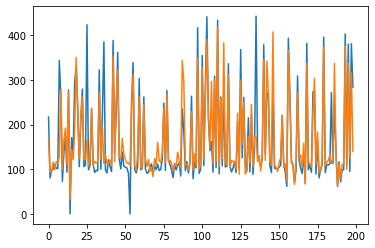

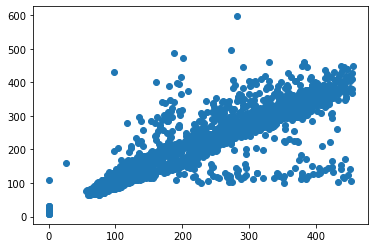

In [53]:
plt.plot(y_test[1:200])
plt.plot(y_pred_LR[1:200])
plt.show()
plt.scatter(y_test,y_pred_LR)

In [54]:
#Evaluate errors
MAE_LR=metrics.mean_absolute_error(y_test,y_pred_LR) 
MSE_LR=metrics.mean_squared_error(y_test,y_pred_LR)  
RMSE_LR= np.sqrt(metrics.mean_squared_error(y_test,y_pred_LR))
cvRMSE_LR=RMSE_LR/np.mean(y_test)
print(MAE_LR, MSE_LR, RMSE_LR,cvRMSE_LR)
MAE_BTl.append(MAE_LR)
MSE_BTl.append(MSE_LR)
RMSE_BTl.append(RMSE_LR)
cvRMSE_BTl.append(cvRMSE_LR)

22.922225837167563 1722.20609572853 41.49947102950265 0.2534569550907725


## Support Vector Regressor

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

sc_X = StandardScaler()
sc_y = StandardScaler()
X_train_SVR = sc_X.fit_transform(X_train)
y_train_SVR = sc_y.fit_transform(y_train.reshape(-1,1))

In [56]:
regr = SVR(kernel='rbf')
regr.fit(X_train_SVR,y_train_SVR)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVR()

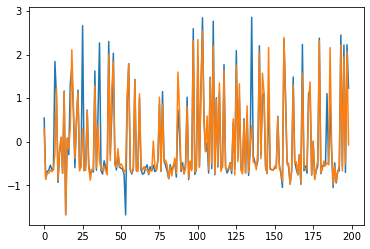

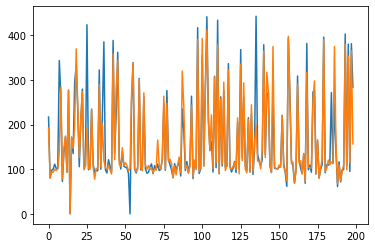

In [57]:
y_pred_SVR = regr.predict(sc_X.fit_transform(X_test))
y_test_SVR=sc_y.fit_transform(y_test.reshape(-1,1))
y_pred_SVR2=sc_y.inverse_transform(y_pred_SVR)
#y_pred_SVR = sc_y.inverse_transform(regr.predict(sc_X.fit_transform(X_test)))
plt.plot(y_test_SVR[1:200])
plt.plot(y_pred_SVR[1:200])
plt.show()
plt.plot(y_test[1:200])
plt.plot(y_pred_SVR2[1:200])

In [58]:
MAE_SVR=metrics.mean_absolute_error(y_test,y_pred_SVR2) 
MSE_SVR=metrics.mean_squared_error(y_test,y_pred_SVR2)  
RMSE_SVR= np.sqrt(metrics.mean_squared_error(y_test,y_pred_SVR2))
cvRMSE_SVR=RMSE_SVR/np.mean(y_test)
print(MAE_SVR, MSE_SVR, RMSE_SVR,cvRMSE_SVR)
MAE_BTl.append(MAE_SVR)
MSE_BTl.append(MSE_SVR)
RMSE_BTl.append(RMSE_SVR)
cvRMSE_BTl.append(cvRMSE_SVR)

14.879704516295922 1163.1079163144427 34.10436799464905 0.20829155294711563


## Decision Tree Regressor

In [59]:
from sklearn.tree import DecisionTreeRegressor
#DecisionTreeRegressor(
#criterion='mse', 
#splitter='best', 
#max_depth=None, 
#min_samples_split=2, 
#min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, 
#max_features=None, 
#random_state=None, 
#max_leaf_nodes=None, 
#min_impurity_decrease=0.0, 
#min_impurity_split=None, 
#presort='deprecated', 
#ccp_alpha=0.0)

# Create Regression Decision Tree object
DT_regr_model = DecisionTreeRegressor()

# Train the model using the training sets
DT_regr_model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_DT = DT_regr_model.predict(X_test)

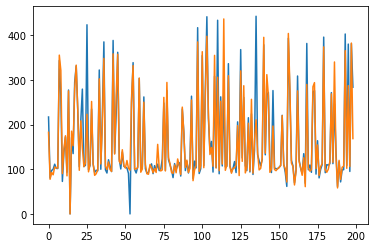

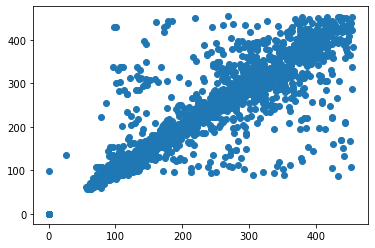

In [60]:
plt.plot(y_test[1:200])
plt.plot(y_pred_DT[1:200])
plt.show()
plt.scatter(y_test,y_pred_DT)

In [61]:
#Evaluate errors
MAE_DT=metrics.mean_absolute_error(y_test,y_pred_DT) 
MSE_DT=metrics.mean_squared_error(y_test,y_pred_DT)  
RMSE_DT= np.sqrt(metrics.mean_squared_error(y_test,y_pred_DT))
cvRMSE_DT=RMSE_DT/np.mean(y_test)
print(MAE_DT, MSE_DT, RMSE_DT,cvRMSE_DT)
MAE_BTl.append(MAE_DT)
MSE_BTl.append(MSE_DT)
RMSE_BTl.append(RMSE_DT)
cvRMSE_BTl.append(cvRMSE_DT)

17.091284896088595 1560.8637059928365 39.507767666534086 0.24129267787713796


## Random forest

In [62]:
from sklearn.ensemble import RandomForestRegressor

In [63]:
parameters = {'bootstrap': True,
              'min_samples_leaf': 3,
              'n_estimators': 200, 
              'min_samples_split': 15,
              'max_features': 'sqrt',
              'max_depth': 20,
              'max_leaf_nodes': None}
RF_model = RandomForestRegressor(**parameters)
#RF_model = RandomForestRegressor()
RF_model.fit(X_train, y_train)
y_pred_RF = RF_model.predict(X_test)

In [64]:
#Evaluate errors
MAE_RF=metrics.mean_absolute_error(y_test,y_pred_RF) 
MSE_RF=metrics.mean_squared_error(y_test,y_pred_RF)  
RMSE_RF= np.sqrt(metrics.mean_squared_error(y_test,y_pred_RF))
cvRMSE_RF=RMSE_RF/np.mean(y_test)
print(MAE_RF,MSE_RF,RMSE_RF,cvRMSE_RF)
MAE_BTl.append(MAE_RF)
MSE_BTl.append(MSE_RF)
RMSE_BTl.append(RMSE_RF)
cvRMSE_BTl.append(cvRMSE_RF)

13.508779307706682 837.7460649408164 28.943843299410265 0.17677378070861885


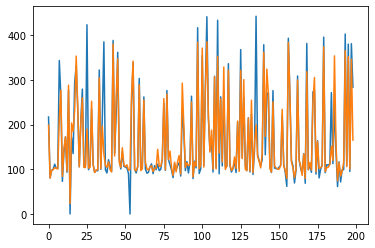

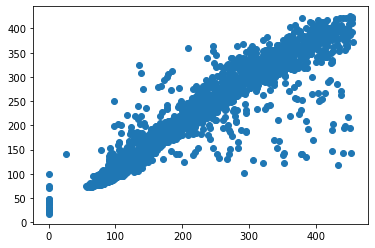

In [65]:
plt.plot(y_test[1:200])
plt.plot(y_pred_RF[1:200])
plt.show()
plt.scatter(y_test,y_pred_RF)

## Uniformized data

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Random forest uniformized data

In [67]:
parameters = {'bootstrap': True,
              'min_samples_leaf': 3,
              'n_estimators': 100, 
              'min_samples_split': 15,
              'max_features': 'sqrt',
              'max_depth': 10,
              'max_leaf_nodes': None}

UDRF_model = RandomForestRegressor(**parameters)
UDRF_model.fit(X_train_scaled, y_train.reshape(-1,1))
y_pred_UDRF = RF_model.predict(X_test_scaled)

<ipython-input-67-39608214bf1b>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  UDRF_model.fit(X_train_scaled, y_train.reshape(-1,1))


In [68]:
#Evaluate errors
MAE_UDRF=metrics.mean_absolute_error(y_test,y_pred_UDRF) 
MSE_UDRF=metrics.mean_squared_error(y_test,y_pred_UDRF)  
RMSE_UDRF= np.sqrt(metrics.mean_squared_error(y_test,y_pred_UDRF))
cvRMSE_UDRF=RMSE_UDRF/np.mean(y_test)
print(MAE_UDRF,MSE_UDRF,RMSE_UDRF,cvRMSE_UDRF)
MAE_BTl.append(MAE_UDRF)
MSE_BTl.append(MSE_UDRF)
RMSE_BTl.append(RMSE_UDRF)
cvRMSE_BTl.append(cvRMSE_UDRF)

108.13696716255248 21265.660736028676 145.8275033593755 0.8906377371335777


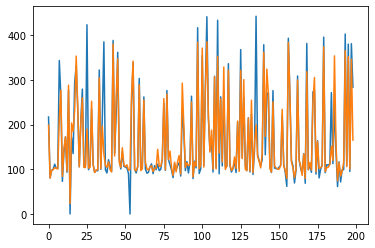

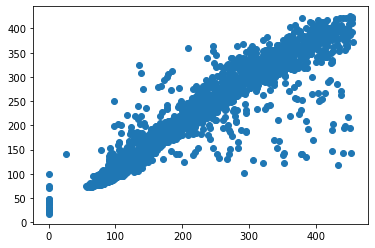

In [69]:
plt.plot(y_test[1:200])
plt.plot(y_pred_RF[1:200])
plt.show()
plt.scatter(y_test,y_pred_RF)

In [70]:
## Gradient Boosting

In [71]:
from sklearn.ensemble import GradientBoostingRegressor

#params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
#          'learning_rate': 0.01, 'loss': 'ls'}
#GB_model = GradientBoostingRegressor(**params)

GB_model = GradientBoostingRegressor()
GB_model.fit(X_train, y_train)
y_pred_GB =GB_model.predict(X_test)

In [72]:
MAE_GB=metrics.mean_absolute_error(y_test,y_pred_GB) 
MSE_GB=metrics.mean_squared_error(y_test,y_pred_GB)  
RMSE_GB= np.sqrt(metrics.mean_squared_error(y_test,y_pred_GB))
cvRMSE_GB=RMSE_GB/np.mean(y_test)
print(MAE_GB,MSE_GB,RMSE_GB,cvRMSE_GB)
MAE_BTl.append(MAE_GB)
MSE_BTl.append(MSE_GB)
RMSE_BTl.append(RMSE_GB)
cvRMSE_BTl.append(cvRMSE_GB)

14.477429414640788 909.0808437832118 30.15096754306919 0.18414626107099588


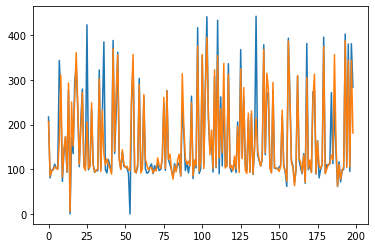

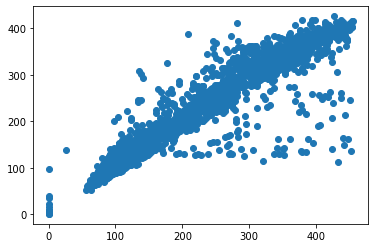

In [73]:
plt.plot(y_test[1:200])
plt.plot(y_pred_GB[1:200])
plt.show()
plt.scatter(y_test,y_pred_GB)

In [74]:
## Bootstrapping

In [75]:
from sklearn.ensemble import BaggingRegressor

BT_model = BaggingRegressor()
BT_model.fit(X_train, y_train)
y_pred_BT =BT_model.predict(X_test)

In [76]:
MAE_BT=metrics.mean_absolute_error(y_test,y_pred_BT) 
MSE_BT=metrics.mean_squared_error(y_test,y_pred_BT)  
RMSE_BT= np.sqrt(metrics.mean_squared_error(y_test,y_pred_BT))
cvRMSE_BT=RMSE_BT/np.mean(y_test)
print(MAE_BT,MSE_BT,RMSE_BT,cvRMSE_BT)
MAE_BTl.append(MAE_BT)
MSE_BTl.append(MSE_BT)
RMSE_BTl.append(RMSE_BT)
cvRMSE_BTl.append(cvRMSE_BT)

13.569818288619226 893.6846608348897 29.894559050684954 0.18258025277915713


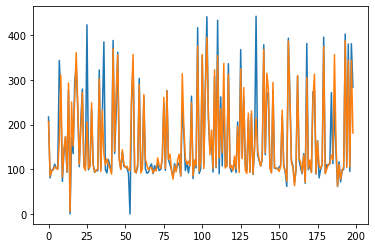

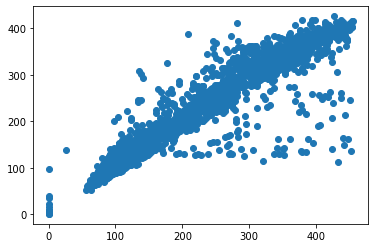

In [77]:
plt.plot(y_test[1:200])
plt.plot(y_pred_GB[1:200])
plt.show()
plt.scatter(y_test,y_pred_GB)

In [78]:
## Neural Networks

In [79]:
from sklearn.neural_network import MLPRegressor

NN_model = MLPRegressor(hidden_layer_sizes=(10,10,10,10))
NN_model.fit(X_train,y_train)
y_pred_NN = NN_model.predict(X_test)

D:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [80]:
MAE_NN=metrics.mean_absolute_error(y_test,y_pred_NN) 
MSE_NN=metrics.mean_squared_error(y_test,y_pred_NN)  
RMSE_NN= np.sqrt(metrics.mean_squared_error(y_test,y_pred_NN))
cvRMSE_NN=RMSE_NN/np.mean(y_test)
print(MAE_NN,MSE_NN,RMSE_NN,cvRMSE_NN)
MAE_BTl.append(MAE_NN)
MSE_BTl.append(MSE_NN)
RMSE_BTl.append(RMSE_NN)
cvRMSE_BTl.append(cvRMSE_NN)

19.96212839416723 1350.6683895928486 36.75144064649505 0.22445848128612927


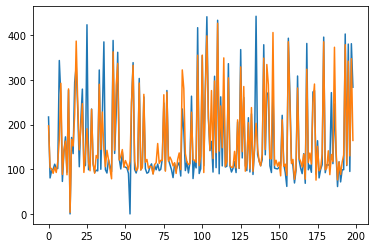

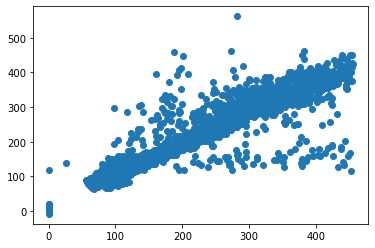

In [81]:
plt.plot(y_test[1:200])
plt.plot(y_pred_NN[1:200])
plt.show()
plt.scatter(y_test,y_pred_NN)

In [82]:
# Best model evaluation

In [83]:
errors= ["MAE", "MSE", "RMSE", "cvRMSE"]
models= ['Linear regression','Support Vector Regression', 'Decision Tree','Random Forest','Random Forest uniformized data','Gradient Boosting','Bootstrapping','Neural Networks']
results = [[MAE_LR, MSE_LR, RMSE_LR, cvRMSE_LR],
[MAE_SVR, MSE_SVR, RMSE_SVR, cvRMSE_SVR],
[MAE_DT, MSE_DT, RMSE_DT, cvRMSE_DT],
[MAE_RF, MSE_RF, RMSE_RF, cvRMSE_RF],
[MAE_UDRF, MSE_UDRF, RMSE_UDRF, cvRMSE_UDRF],
[MAE_GB, MSE_GB, RMSE_GB, cvRMSE_GB],
[MAE_BT, MSE_BT, RMSE_BT, cvRMSE_BT],
[MAE_NN, MSE_NN, RMSE_NN, cvRMSE_NN]]
Table=pd.DataFrame(results, models, errors)
Table

,MAE,MSE,RMSE,cvRMSE
Linear regression,22.922226,1722.206096,41.499471,0.253457
Support Vector Regression,14.879705,1163.107916,34.104368,0.208292
Decision Tree,17.091285,1560.863706,39.507768,0.241293
Random Forest,13.508779,837.746065,28.943843,0.176774
Random Forest uniformized data,108.136967,21265.660736,145.827503,0.890638
Gradient Boosting,14.477429,909.080844,30.150968,0.184146
Bootstrapping,13.569818,893.684661,29.894559,0.182580
Neural Networks,19.962128,1350.668390,36.751441,0.224458


In [84]:
best=min(MAE_BTl)
best_index=MAE_BTl.index(best) +1
print("The lowest error is ", str(best)," hence the best method is ", models[best_index-1])

The lowest error is  13.508779307706682  hence the best method is  Random Forest
